In [8]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random


In [9]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [10]:
#  loading training data
training_set = Datasets.CIFAR10(root='./', download=True,
                                transform=transforms.ToTensor())

#  loading validation data
validation_set = Datasets.CIFAR10(root='./', download=True, train=False,
                                  transform=transforms.ToTensor())

In [11]:
def extract_each_class(dataset):
  """
  This function searches for and returns
  one image per class
  """
  images = []
  ITERATE = True
  i = 0
  j = 0

  while ITERATE:
    for label in tqdm_regular(dataset.targets):
      if label==j:
        images.append(dataset.data[i])
        print(f'class {j} found')
        i+=1
        j+=1
        if j==10:
          ITERATE = False
      else:
        i+=1

  return images
  
  
#  extracting training images
training_images = [x for x in training_set.data]

#  extracting validation images
validation_images = [x for x in validation_set.data]

#  extracting one image from each class in the validation set
test_images = extract_each_class(validation_set)

100%|██████████| 10000/10000 [00:00<00:00, 4109645.31it/s]

class 0 found
class 1 found
class 2 found
class 3 found
class 4 found
class 5 found
class 6 found
class 7 found
class 8 found
class 9 found


In [12]:
#  converting images to grayscale by taking mean across axis-2 (depth)
training_gray = [x.mean(axis=2) for x in training_images]
validation_gray = [x.mean(axis=2) for x in validation_images]
test_gray = [x.mean(axis=2) for x in test_images]

In [13]:
def min_max_normalize_gray(dataset: list):
  """
  This function normalizes data by constraining
  data points between the range of 0 & 1  
  """
  #  create a list to hold normalized data  
  normalized = []

  for image in tqdm_regular(dataset):
    #  creating temporary store
    temp = []
    #  flatenning
    pixels = image.flatten()
    #  derive minimum and maximum values
    minimum = pixels.min()
    maximum = pixels.max()
    #  convert to list for iteration
    pixels = list(pixels)

    for pixel in pixels:
      #  normalizing pixels
      normalize = (pixel-minimum)/(maximum-minimum)
      #  appending each pixel to temporary store
      temp.append(round(normalize, 2))

    temp = np.array(temp)
    temp = temp.reshape((32, 32))
    #  appending normalized image to list
    normalized.append(temp)
  
  return normalized
  
  
#  normalizing pixels
training_gray = min_max_normalize_gray(training_gray)
validation_gray = min_max_normalize_gray(validation_gray)
test_gray = min_max_normalize_gray(test_gray)

100%|██████████| 10/10 [00:00<00:00, 431.38it/s]


In [14]:
def random_noise(dataset: list, noise_intensity=0.2):
  """
  This function replicates the salt and pepper noise process
  """
  noised = []
  noise_threshold = 1 - noise_intensity

  for image in tqdm_regular(dataset):
    #  flatenning image
    image = image.reshape(1024)

    #  creating vector of zeros
    noise_vector = np.zeros(1024)

    #  noise probability
    for idx in range(1024):
      regulator = round(random.random(), 1)
      if regulator > noise_threshold:
        noise_vector[idx] = 1
      elif regulator == noise_threshold:
        noise_vector[idx] = 0
      else:
        noise_vector[idx] = image[idx]
    
    #  reshaping noise vectors
    noise_vector = noise_vector.reshape((32, 32))

    noised.append(noise_vector)
  return noised
  
  
#  adding noise to images
training_noised = random_noise(training_gray)
validation_noised = random_noise(validation_gray)
test_noised = random_noise(test_gray)

100%|██████████| 10/10 [00:00<00:00, 3316.18it/s]


In [15]:
#  creating image-target pair
training_set = list(zip(training_noised, training_gray))
validation_set = list(zip(validation_noised, validation_gray))
test_set = list(zip(test_noised, test_gray))

In [16]:
#  defining dataset class
class CustomCIFAR10(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx][0]
    target = self.data[idx][1]

    if self.transforms!=None:
      image = self.transforms(image)
      target = self.transforms(target)
    return (image, target)
    
    
#  creating pytorch datasets
training_data = CustomCIFAR10(training_set, transforms=transforms.Compose([transforms.ToTensor(),
                                                                          transforms.Normalize(0.5, 0.5)]))
validation_data = CustomCIFAR10(validation_set, transforms=transforms.Compose([transforms.ToTensor(),
                                                                              transforms.Normalize(0.5, 0.5)]))
test_data = CustomCIFAR10(test_set, transforms=transforms.Compose([transforms.ToTensor(),
                                                                  transforms.Normalize(0.5, 0.5)]))

In [17]:
#  defining encoder
class Encoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=1000, act_fn=nn.ReLU()):
    super().__init__()
    self.in_channels = in_channels

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), # (32, 32)
        act_fn,
        nn.Conv2d(out_channels, out_channels, 3, padding=1), 
        act_fn,
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (16, 16)
        act_fn,
        nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (8, 8)
        act_fn,
        nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
        act_fn,
        nn.Flatten(),
        nn.Linear(4*out_channels*8*8, latent_dim),
        act_fn
    )

  def forward(self, x):
    x = x.view(-1, self.in_channels, 32, 32)
    output = self.net(x)
    return output


#  defining decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=1000, act_fn=nn.ReLU()):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels*8*8),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (8, 8)
        act_fn,
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (16, 16)
        act_fn,
        nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (32, 32)
        act_fn,
        nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 4*self.out_channels, 8, 8)
    output = self.conv(output)
    return output


#  defining autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [18]:
#  defining class
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set, test_set,
            image_channels=3):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)
    test_loader = DataLoader(test_set, 10)

    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images, targets in tqdm(train_loader):
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images and targets to device
        images = images.to(device).type(torch.cuda.FloatTensor)
        targets = targets.to(device).type(torch.cuda.FloatTensor)
        #  reconstructing images
        output = self.network(images)
        #  computing loss
        loss = loss_function(output, targets)
        loss = loss#.type(torch.cuda.FloatTensor)
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images, val_targets in tqdm(val_loader):
        with torch.no_grad():
          #  sending validation images and targets to device
          val_images = val_images.to(device).type(torch.cuda.FloatTensor)
          val_targets = val_targets.to(device).type(torch.cuda.FloatTensor)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_targets)

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      #--------------
      # VISUALISATION
      #--------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

      for test_images, test_targets in test_loader:
        #  sending test images to device
        test_images = test_images.to(device).type(torch.cuda.FloatTensor)
        with torch.no_grad():
          #  reconstructing test images
          reconstructed_imgs = self.network(test_images)
        #  sending reconstructed and images to cpu to allow for visualization
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()

        #  visualisation
        imgs = torch.stack([test_images.view(-1, image_channels, 32, 32), reconstructed_imgs], 
                          dim=1).flatten(0,1)
        grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
        grid = grid.permute(1, 2, 0)
        plt.figure(dpi=170)
        plt.title('Original/Reconstructed')
        plt.imshow(grid)
        log_dict['visualizations'].append(grid)
        plt.axis('off')
        plt.show()
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

Epoch 1/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0556 validation_loss: 0.0592


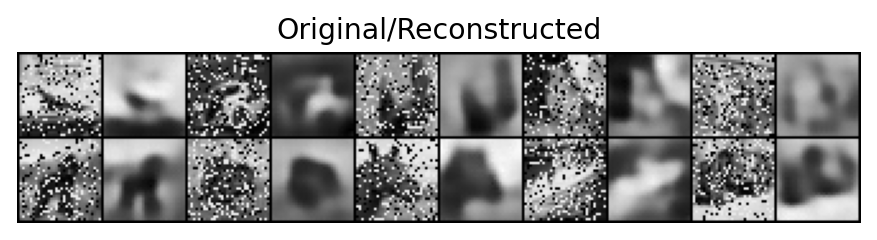

Epoch 2/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0381 validation_loss: 0.0389


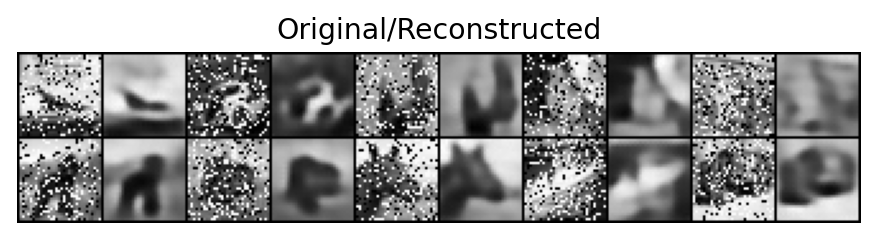

Epoch 3/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0307 validation_loss: 0.03


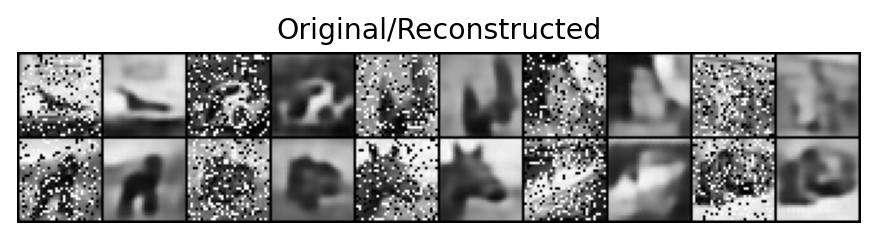

Epoch 4/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.027 validation_loss: 0.0253


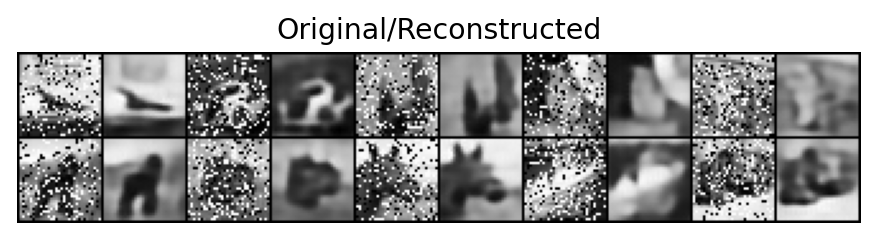

Epoch 5/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0235 validation_loss: 0.0224


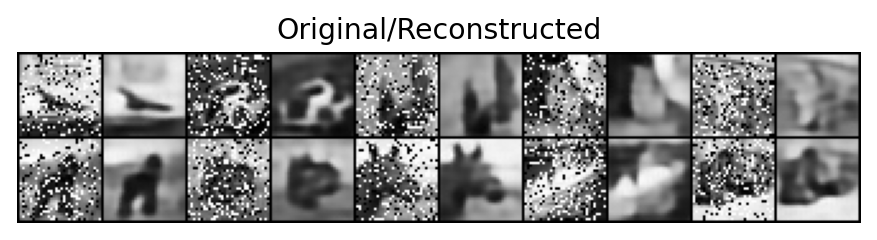

Epoch 6/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0224 validation_loss: 0.0207


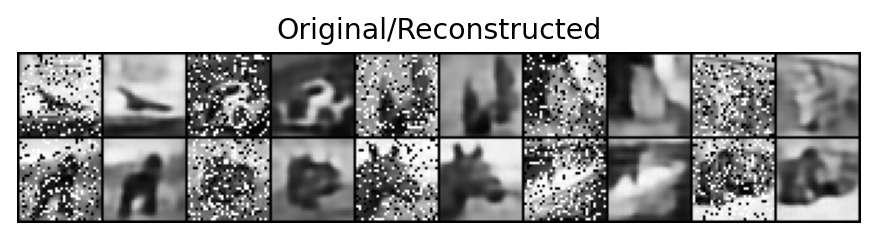

Epoch 7/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0213 validation_loss: 0.0189


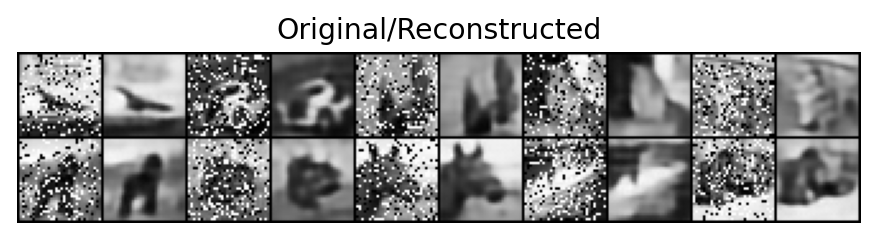

Epoch 8/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0179 validation_loss: 0.0175


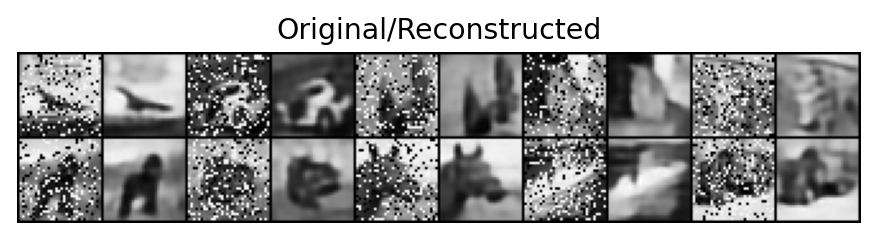

Epoch 9/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0168 validation_loss: 0.0157


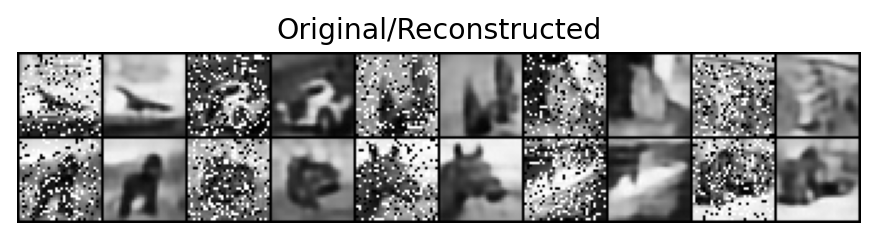

Epoch 10/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0157 validation_loss: 0.0147


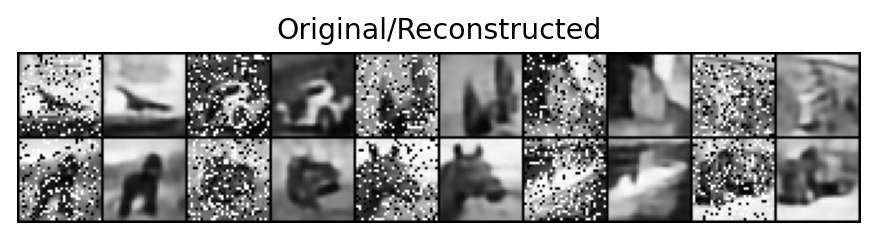

Epoch 11/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0158 validation_loss: 0.0154


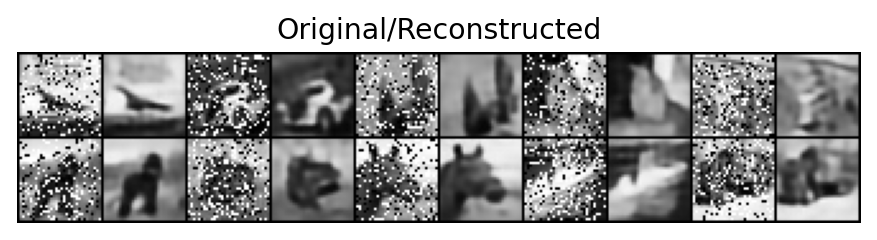

Epoch 12/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0146 validation_loss: 0.0137


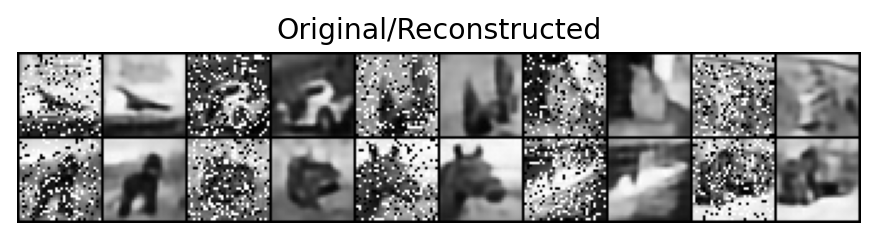

Epoch 13/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.016 validation_loss: 0.0152


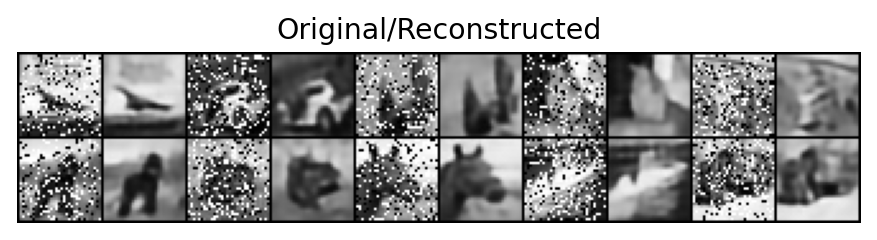

Epoch 14/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0139 validation_loss: 0.0136


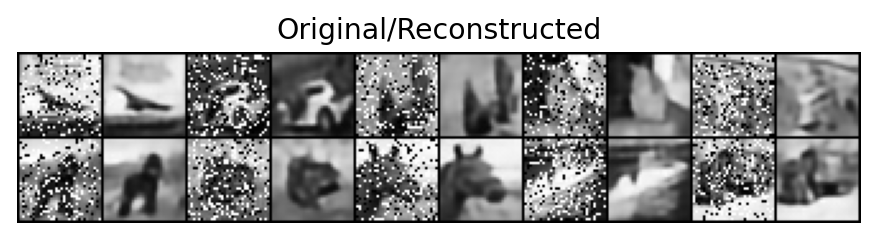

Epoch 15/15
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0136 validation_loss: 0.012


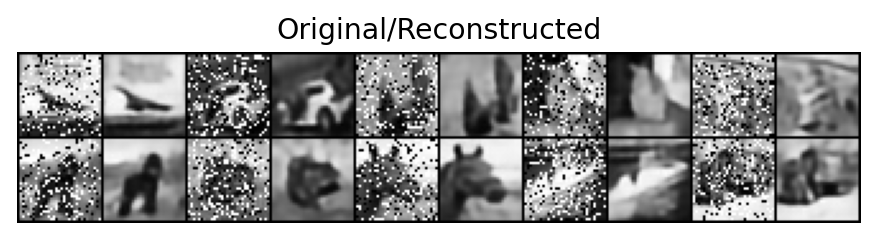

In [19]:
#  training model
model = ConvolutionalAutoencoder(Autoencoder(Encoder(in_channels=1),
                                               Decoder(in_channels=1)))

log_dict = model.train(nn.MSELoss(), epochs=15, batch_size=64, 
                       training_set=training_data, validation_set=validation_data,
                       test_set=test_data, image_channels=1)

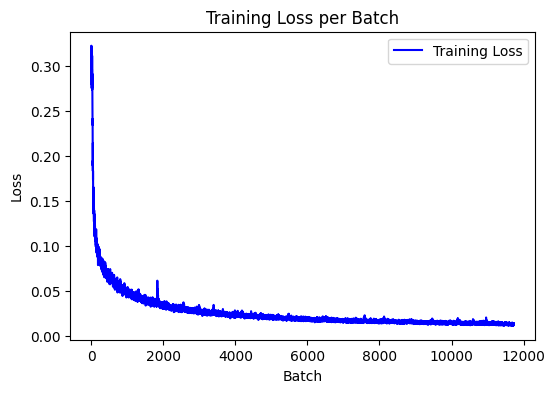

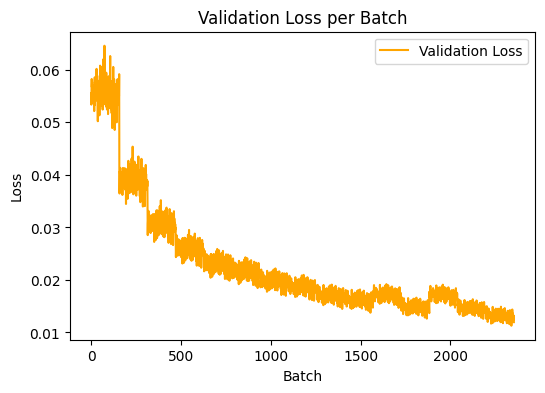

In [21]:
import matplotlib.pyplot as plt

# Training loss plot
plt.figure(figsize=(6,4))
plt.plot(log_dict['training_loss_per_batch'], label='Training Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.show()

# Validation loss plot
plt.figure(figsize=(6,4))
plt.plot(log_dict['validation_loss_per_batch'], label='Validation Loss', color='orange')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss per Batch')
plt.legend()
plt.show()